## ***Reinforcement Learning - 2024***

Stefano Aragoni, Carol Arévalo, José González, Luis Santos

-----------

### *Proyecto Final*

Este proyecto implementa un agente de refuerzo que simula un dispositivo de asistencia para personas ciegas, ayudándolas a cruzar calles en entornos urbanos con tráfico. El agente aprende a determinar el momento adecuado para cruzar una calle, donde los vehículos se mueven dinámicamente, cambiando de posición y apareciendo nuevos en cada paso de la simulación. A través de su interacción con el entorno, el agente observa su posición en el paso de cebra, la ubicación de los vehículos y evalúa si debe avanzar, retroceder o mantenerse en su lugar, con el objetivo de maximizar las recompensas al evitar ser atropellado y alcanzar de forma segura el otro lado de la calle. Este enfoque no solo permite aplicar técnicas de aprendizaje por refuerzo en un entorno complejo y dinámico, sino que también aborda un problema práctico de movilidad y seguridad para personas ciegas, promoviendo su autonomía en situaciones de tráfico.

-----------

#### *Importar librerías*

Como primer paso, se importan las librerías necesarias para el desarrollo del problema.

In [112]:
import numpy as np
import random

import gymnasium as gym
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

import os
from IPython.display import Image as IPImage, display
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

from stable_baselines3.common.callbacks import BaseCallback


# --------------- Callback para obtener los valores de loss del entrenamiento ---------------
class LossLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(LossLoggerCallback, self).__init__(verbose)
        self.losses = []

    def _on_step(self) -> bool:
        loss = self.model.logger.name_to_value.get("train/loss", None)
        if loss is not None:
            self.losses.append(loss)
        return True
# ------------------------------------------------------------------------------------------

-----------

#### *Escenario 1*

En el primer escenario, se presenta un entorno de simulación con un paso de cebra y vehículos que se mueven en una sola dirección. El agente debe aprender a cruzar la calle de forma segura, evitando ser atropellado por los vehículos que se desplazan de izquierda a derecha. El agente recibe una recompensa positiva al llegar al otro lado de la calle y una recompensa negativa si es atropellado.

In [113]:
class CrossStreetEnv(gym.Env):
    def __init__(self, num_lanes=4, street_length=5):
        super(CrossStreetEnv, self).__init__()

        # Definir dimensiones del entorno con aceras (arriba y abajo)
        self.num_lanes = num_lanes
        self.street_length = street_length
        self.observation_shape = (self.num_lanes + 2, self.street_length)  # +2 para las aceras
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=self.observation_shape, dtype=np.float32)
        self.action_space = gym.spaces.Discrete(3)

        # Variables para el registro de métricas
        self.total_rewards = []       # Recompensas acumuladas en cada episodio
        self.successful_episodes = 0  # Contador de episodios exitosos
        self.steps_per_episode = []   # Número de pasos por episodio
        self.rewards_history = []     # Histórico de recompensas acumuladas

        self.frames = []

        # Inicializar estado
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.np_random, _ = gym.utils.seeding.np_random(seed)

        # Limpiar y preparar directorio de frames
        for frame in os.listdir("./frames"): 
            os.remove(f"./frames/{frame}")
        self.frames = []
        
        # Posición inicial del agente en la acera inferior
        self.agent_position = [self.num_lanes + 1, 0]  
        self.vehicles = self._generate_vehicles()
        
        # Contador de pasos y recompensa acumulada
        self.current_steps = 0
        self.episode_reward = 0
        state = self._get_state().astype(np.float32)
        return state, {}

    def step(self, action):
        reward = -1  # Penalizar cada paso
        done = False
        
        # Mover al agente según la acción
        if action == 0:  # Retrocede
            self.agent_position[0] = max(0, self.agent_position[0] - 1)
            reward -= 2  # Penalización adicional por retroceder
        elif action == 1:  # Queda en su lugar
            # Revisar si los últimos 10 episodios han tenido un reward de -1
            reward -= 2
            if len(self.rewards_history) > 10 and all([r == -3 for r in self.rewards_history[-10:]]):
                done = True
                reward -= 10
        elif action == 2:  # Avanza
            self.agent_position[0] = min(self.num_lanes, self.agent_position[0] + 1)
            reward += 1  # Recompensa por avanzar en la dirección correcta
        
        # Movimientos de vehículos
        self.vehicles = [(pos - 1) % self.street_length for pos in self.vehicles]
        
        # Revisar éxito o colisión
        if self.agent_position[0] == 0:  # Cruzó con éxito
            reward += 20
            done = True
            self.successful_episodes += 1  # Registrar episodio exitoso
        elif self._is_collision():  # Colisión
            reward -= 20
            done = True

        # Actualizar recompensa acumulada y registro de pasos
        self.episode_reward += reward
        self.current_steps += 1

        self.record_episode_stats()

        state = self._get_state().astype(np.float32)
        return state, reward, done, False, {}

    def _generate_vehicles(self):
        # Genera vehículos en posiciones aleatorias en cada carril (excluyendo las aceras)
        return [self.np_random.choice(range(self.street_length)) for _ in range(self.num_lanes)]

    def _is_collision(self):
        row, col = self.agent_position
        return 1 <= row <= self.num_lanes and col == self.vehicles[row - 1]

    def _get_state(self):
        state = np.zeros(self.observation_shape, dtype=np.float32)
        
        # Posición del agente
        state[self.agent_position[0], self.agent_position[1]] = 1
        
        # Colocar vehículos en los carriles
        for i, vehicle_pos in enumerate(self.vehicles):
            state[i + 1, vehicle_pos] = 0.5  # +1 para alinear con los carriles (excluyendo las aceras)

        return state

    def record_episode_stats(self):
        self.total_rewards.append(self.episode_reward)
        self.steps_per_episode.append(self.current_steps)
        self.rewards_history.append(self.episode_reward)

    def plot_training_metrics(self, loss):
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))

        # Gráfico 1: Recompensa acumulada por episodio
        axs[0][0].plot(self.total_rewards, label="Recompensa acumulada")
        axs[0][0].set_title("Recompensa acumulada por episodio")
        axs[0][0].set_xlabel("Episodio")
        axs[0][0].set_ylabel("Recompensa acumulada")
        axs[0][0].legend()

        # Gráfico 2: Cantidad de episodios exitosos
        successful_ratio = [sum(self.total_rewards[:i+1]) / (i+1) for i in range(len(self.total_rewards))]
        axs[0][1].plot(successful_ratio, label="Proporción de éxitos", color="green")
        axs[0][1].set_title("Proporción de episodios exitosos")
        axs[0][1].set_xlabel("Episodio")
        axs[0][1].set_ylabel("Proporción de éxitos")
        axs[0][1].legend()

        # Gráfico 3: Pasos por episodio
        axs[1][0].plot(self.steps_per_episode, label="Pasos por episodio", color="orange")
        axs[1][0].set_title("Número de pasos por episodio")
        axs[1][0].set_xlabel("Episodio")
        axs[1][0].set_ylabel("Pasos")
        axs[1][0].legend()

        # Gráfico 4: Loss de la red neuronal
        axs[1][1].plot(loss, label="Loss", color="red")
        axs[1][1].set_title("Loss de la red neuronal")
        axs[1][1].set_xlabel("Paso")
        axs[1][1].set_ylabel("Loss")
        axs[1][1].legend()

        plt.tight_layout()
        plt.show()
    

    def render(self):
        fig, ax = plt.subplots(figsize=(8+(self.street_length//4), 6+(self.num_lanes//4)))
        ax.set_xlim(-0.5, self.street_length - 0.5)
        ax.set_ylim(-0.5, self.num_lanes + 1.5)
        ax.set_xticks(range(self.street_length))
        ax.set_yticks(range(self.num_lanes + 2))
        ax.axis("off")

        # Load PNG images for agent and cars
        person_img = mpimg.imread("./imgs/personU.png")
        car_img = mpimg.imread("./imgs/carL.png")

        # Draw sidewalks (top and bottom)
        for x in range(self.street_length):
            ax.add_patch(patches.Rectangle((x - 0.5, -0.5), 1, 1, color="lightgray"))  # Bottom sidewalk
            ax.add_patch(patches.Rectangle((x - 0.5, self.num_lanes + 0.5), 1, 1, color="lightgray"))  # Top sidewalk

        # Draw street lanes and white lines between lanes
        skip = 0
        for lane in range(1, self.num_lanes + 1):
            for x in range(self.street_length):
                ax.add_patch(patches.Rectangle((x - 0.5, lane - 0.5), 1, 1, color="darkgray"))
            
            # Draw white lines between lanes
            if skip == 0:
                skip = 1
            else:
                if lane < self.num_lanes + 1:
                    for x in range(self.street_length):
                        ax.add_patch(patches.Rectangle((x + 0.5, lane - 0.5), 1, 0.02, color="white"))

        # Draw a pedestrian crossing (zebra crossing) at x=0
        for lane in range(1, self.num_lanes+1):
            ax.add_patch(patches.Rectangle((-0.5, lane-0.5), 1, 0.25, color="white"))

            ax.add_patch(patches.Rectangle((-0.5, lane), 1, 0.25, color="white"))

        # Initialize agent and vehicle images as AnnotationBbox (to allow updating)
        agent_annot = AnnotationBbox(OffsetImage(person_img, zoom=0.01), 
                                    (self.agent_position[1], self.num_lanes + 1 - self.agent_position[0]), 
                                    frameon=False)
        ax.add_artist(agent_annot)
        
        vehicle_annots = []
        for lane in range(self.num_lanes):
            vehicle_pos = self.vehicles[lane]
            vehicle_annot = AnnotationBbox(OffsetImage(car_img, zoom=0.15), 
                                        (vehicle_pos, self.num_lanes - lane), 
                                        frameon=False)
            vehicle_annots.append(vehicle_annot)
            ax.add_artist(vehicle_annot)

        # Update function for animation
        def update(frame):
            # Example agent movement
            self.agent_position[1] = (self.agent_position[1] + 1) % self.street_length
            agent_annot.xy = (self.agent_position[1], self.num_lanes + 1 - self.agent_position[0])
            
            # Example vehicle movement
            for lane in range(self.num_lanes):
                self.vehicles[lane] = (self.vehicles[lane] - 1) % self.street_length
                vehicle_annots[lane].xy = (self.vehicles[lane], self.num_lanes - lane)
            
            return [agent_annot] + vehicle_annots

        
        # Save the frame on ./frames folder as PNG
        self.frames.append(f"./frames/frame_{len(self.frames)}.png")
        plt.savefig(self.frames[-1])
        plt.close(fig)

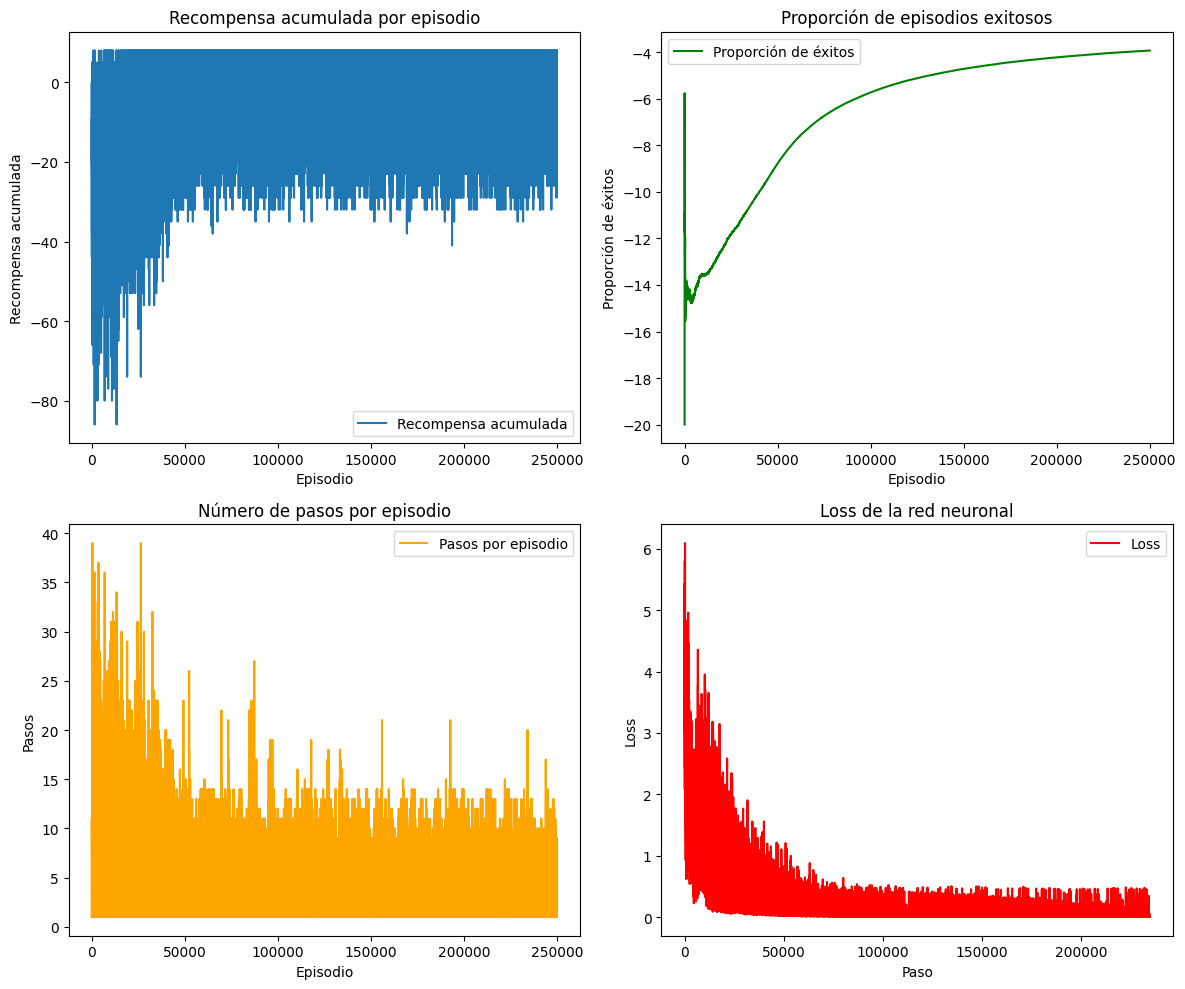

In [114]:
# Configuración del entorno y revisión
env = CrossStreetEnv(num_lanes=4, street_length=10)
check_env(env)

# Configuración de la red neuronal
policy_kwargs = dict(net_arch=[128, 128])
model = DQN(
    "MlpPolicy",
    env,
    policy_kwargs=policy_kwargs,
    learning_rate=5e-4,
    buffer_size=100000,
    learning_starts=1000,
    batch_size=64,
    target_update_interval=1000,
    exploration_fraction=0.2,
    exploration_final_eps=0.05,
    verbose=0
)

# Entrenamiento del modelo con callback
loss_callback = LossLoggerCallback()
model.learn(total_timesteps=250000, callback=loss_callback)

# Graficar métricas de entrenamiento
env.plot_training_metrics(loss_callback.losses)

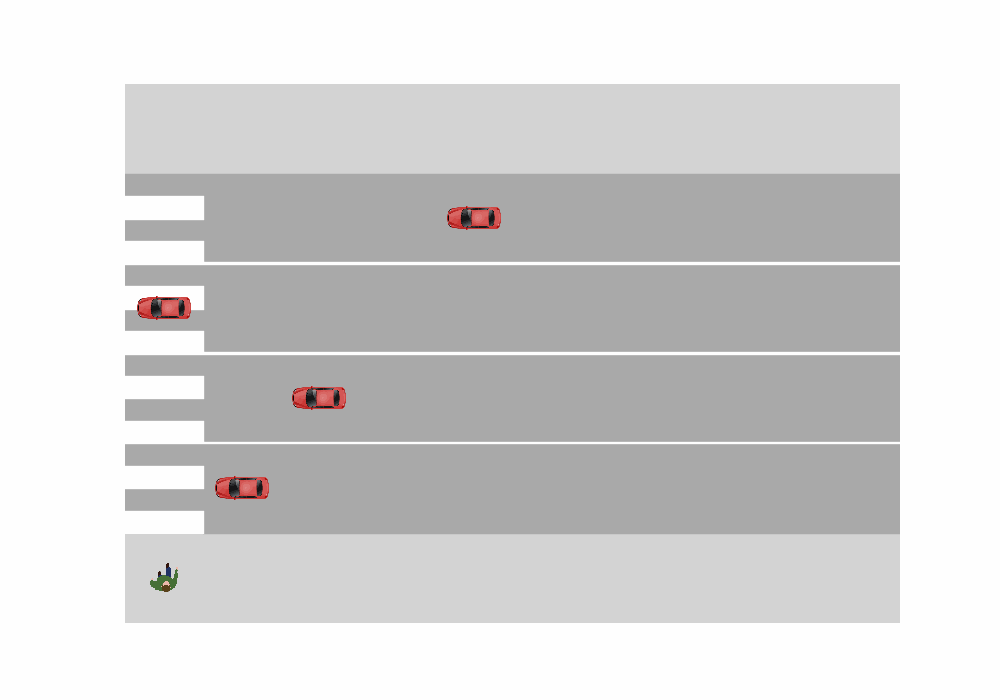

In [139]:
# Evaluación y visualización
obs, _ = env.reset()
env.render()

done = False
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = env.step(action)
    env.render()  # Visualización de cada paso para pruebas

# Crear animación con los frames guardados
frames = [Image.open(frame) for frame in env.frames]
frames[0].save("cross_street_animation.gif", save_all=True, append_images=frames[1:], loop=0, duration=300)

display(IPImage(filename="cross_street_animation.gif"))

-----------

#### *Escenario 2*

En el segundo escenario, se presenta un entorno de simulación con un paso de cebra y vehículos que se mueven en ambas direcciones. El agente debe aprender a cruzar la calle de forma segura, evitando ser atropellado por los vehículos que se desplazan en ambas direcciones. El agente recibe una recompensa positiva al llegar al otro lado de la calle y una recompensa negativa si es atropellado.

In [116]:
class CrossStreetEnv2(gym.Env):
    def __init__(self, num_lanes=4, street_length=10):
        super(CrossStreetEnv2, self).__init__()

        num_lanes = int((num_lanes//2)*2)            # Asegurar que el número de carriles sea par
        street_length = max(10, street_length)

        # Definir dimensiones del entorno con aceras (arriba y abajo)
        self.num_lanes = num_lanes
        self.street_length = street_length
        self.observation_shape = (self.num_lanes + 2, self.street_length)  # +2 para las aceras
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=self.observation_shape, dtype=np.float32)
        self.action_space = gym.spaces.Discrete(3)

        # Variables para el registro de métricas
        self.total_rewards = []       # Recompensas acumuladas en cada episodio
        self.successful_episodes = 0  # Contador de episodios exitosos
        self.steps_per_episode = []   # Número de pasos por episodio
        self.rewards_history = []     # Histórico de recompensas acumuladas

        self.frames = []

        # Inicializar estado
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.np_random, _ = gym.utils.seeding.np_random(seed)

        # Limpiar y preparar directorio de frames
        for frame in os.listdir("./frames"): 
            os.remove(f"./frames/{frame}")
        self.frames = []
        
        # Posición inicial del agente en la acera inferior
        self.agent_position = [self.num_lanes+1, self.street_length // 2]
        self.vehicles = self._generate_vehicles()
        
        # Contador de pasos y recompensa acumulada
        self.current_steps = 0
        self.episode_reward = 0
        state = self._get_state().astype(np.float32)
        return state, {}

    def step(self, action):
        reward = -1  # Penalize each step
        done = False

        # Mover al agente según la acción
        if action == 0:  # Retrocede
            self.agent_position[0] = max(0, self.agent_position[0] - 1)
            reward -= 2  # Penalización adicional por retroceder
        elif action == 1:  # Queda en su lugar
            # Revisar si los últimos 10 episodios han tenido un reward de -1
            reward -= 2
            if len(self.rewards_history) > 10 and all([r == -3 for r in self.rewards_history[-10:]]):
                done = True
                reward -= 10
        elif action == 2:  # Avanza
            self.agent_position[0] = min(self.num_lanes, self.agent_position[0] + 1)
            reward += 1  # Recompensa por avanzar en la dirección correcta

        # Update vehicle positions based on direction
        for i in range(self.num_lanes):
            if i < self.num_lanes // 2:  # First half lanes: vehicles move left to right
                self.vehicles[i] = (self.vehicles[i] + 1) % self.street_length
            else:  # Second half lanes: vehicles move right to left
                self.vehicles[i] = (self.vehicles[i] - 1) % self.street_length

        # Check for success or collision
        if self.agent_position[0] == 0:  # Successful crossing
            reward += 20
            done = True
            self.successful_episodes += 1
        elif self._is_collision():  # Collision
            reward -= 20
            done = True

        # Update accumulated reward and step count
        self.episode_reward += reward
        self.current_steps += 1

        self.record_episode_stats()

        state = self._get_state().astype(np.float32)
        return state, reward, done, False, {}

    def _generate_vehicles(self):
        # Generate vehicles at random positions for each lane
        return [self.np_random.choice(range(self.street_length)) for _ in range(self.num_lanes)]

    def _is_collision(self):
        row, col = self.agent_position
        return 1 <= row <= self.num_lanes and col == self.vehicles[row - 1]

    def _get_state(self):
        state = np.zeros(self.observation_shape, dtype=np.float32)
        
        # Posición del agente
        state[self.agent_position[0], self.agent_position[1]] = 1
        
        # Colocar vehículos en los carriles
        for i, vehicle_pos in enumerate(self.vehicles):
            state[i + 1, vehicle_pos] = 0.5  # +1 para alinear con los carriles (excluyendo las aceras)

        return state

    def record_episode_stats(self):
        self.total_rewards.append(self.episode_reward)
        self.steps_per_episode.append(self.current_steps)
        self.rewards_history.append(self.episode_reward)

    def plot_training_metrics(self, loss):
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))

        # Gráfico 1: Recompensa acumulada por episodio
        axs[0][0].plot(self.total_rewards, label="Recompensa acumulada")
        axs[0][0].set_title("Recompensa acumulada por episodio")
        axs[0][0].set_xlabel("Episodio")
        axs[0][0].set_ylabel("Recompensa acumulada")
        axs[0][0].legend()

        # Gráfico 2: Cantidad de episodios exitosos
        successful_ratio = [sum(self.total_rewards[:i+1]) / (i+1) for i in range(len(self.total_rewards))]
        axs[0][1].plot(successful_ratio, label="Proporción de éxitos", color="green")
        axs[0][1].set_title("Proporción de episodios exitosos")
        axs[0][1].set_xlabel("Episodio")
        axs[0][1].set_ylabel("Proporción de éxitos")
        axs[0][1].legend()

        # Gráfico 3: Pasos por episodio
        axs[1][0].plot(self.steps_per_episode, label="Pasos por episodio", color="orange")
        axs[1][0].set_title("Número de pasos por episodio")
        axs[1][0].set_xlabel("Episodio")
        axs[1][0].set_ylabel("Pasos")
        axs[1][0].legend()

        # Gráfico 4: Loss de la red neuronal
        axs[1][1].plot(loss, label="Loss", color="red")
        axs[1][1].set_title("Loss de la red neuronal")
        axs[1][1].set_xlabel("Paso")
        axs[1][1].set_ylabel("Loss")
        axs[1][1].legend()

        plt.tight_layout()
        plt.show()
    

    def render(self):
        fig, ax = plt.subplots(figsize=(8+(self.street_length//4), 6+(self.num_lanes//4)))
        ax.set_xlim(-0.5, self.street_length - 0.5)
        ax.set_ylim(-0.5, self.num_lanes + 1.5)
        ax.set_xticks(range(self.street_length))
        ax.set_yticks(range(self.num_lanes + 2))
        ax.axis("off")

        # Load PNG images for agent and cars
        person_img = mpimg.imread("./imgs/personU.png")
        carL_img = mpimg.imread("./imgs/carL.png")
        carR_img = mpimg.imread("./imgs/carR.png")

        # Draw sidewalks (top and bottom)
        for x in range(self.street_length):
            ax.add_patch(patches.Rectangle((x - 0.5, -0.5), 1, 1, color="lightgray"))  # Bottom sidewalk
            ax.add_patch(patches.Rectangle((x - 0.5, self.num_lanes + 0.5), 1, 1, color="lightgray"))  # Top sidewalk

        # Draw street lanes and white lines between lanes
        skip = 0
        for lane in range(1, self.num_lanes + 1):
            for x in range(self.street_length):
                ax.add_patch(patches.Rectangle((x - 0.5, lane - 0.5), 1, 1, color="darkgray"))
            
            # Draw white lines between lanes
            if skip == 0:
                skip = 1
            else:
                if lane < self.num_lanes + 1:
                    for x in range(self.street_length):
                        ax.add_patch(patches.Rectangle((x - 0.5 , lane - 0.5), 1, 0.02, color="white"))

        # Draw a pedestrian crossing (zebra crossing) at x=0
        for lane in range(1, self.num_lanes+1):
            ax.add_patch(patches.Rectangle(((self.street_length // 2)-0.5, lane-0.5), 1, 0.25, color="white"))

            ax.add_patch(patches.Rectangle(((self.street_length // 2)-0.5, lane), 1, 0.25, color="white"))

        # Initialize agent and vehicle images as AnnotationBbox (to allow updating)
        agent_annot = AnnotationBbox(OffsetImage(person_img, zoom=0.01), 
                                    (self.agent_position[1], self.num_lanes + 1 - self.agent_position[0]), 
                                    frameon=False)
        ax.add_artist(agent_annot)
        
        vehicle_annots = []
        for lane in range(self.num_lanes):
            vehicle_pos = self.vehicles[lane]
            
            # Select the correct car image based on lane direction
            if lane < self.num_lanes // 2:
                car_img = carR_img  # Rightward-moving car
            else:
                car_img = carL_img  # Leftward-moving car

            # Add vehicle annotation
            vehicle_annot = AnnotationBbox(OffsetImage(car_img, zoom=0.2), 
                                        (vehicle_pos, self.num_lanes - lane), 
                                        frameon=False)
            vehicle_annots.append(vehicle_annot)
            ax.add_artist(vehicle_annot)

        # Update function for animation
        def update(frame):
            # Example agent movement
            self.agent_position[1] = (self.agent_position[1] + 1) % self.street_length
            agent_annot.xy = (self.agent_position[1], self.num_lanes + 1 - self.agent_position[0])
            
            # Example vehicle movement
            for lane in range(self.num_lanes):
                self.vehicles[lane] = (self.vehicles[lane] - 1) % self.street_length
                vehicle_annots[lane].xy = (self.vehicles[lane], self.num_lanes - lane)
            
            return [agent_annot] + vehicle_annots

        
        # Save the frame on ./frames folder as PNG
        self.frames.append(f"./frames/frame2_{len(self.frames)}.png")
        plt.savefig(self.frames[-1])
        plt.close(fig)

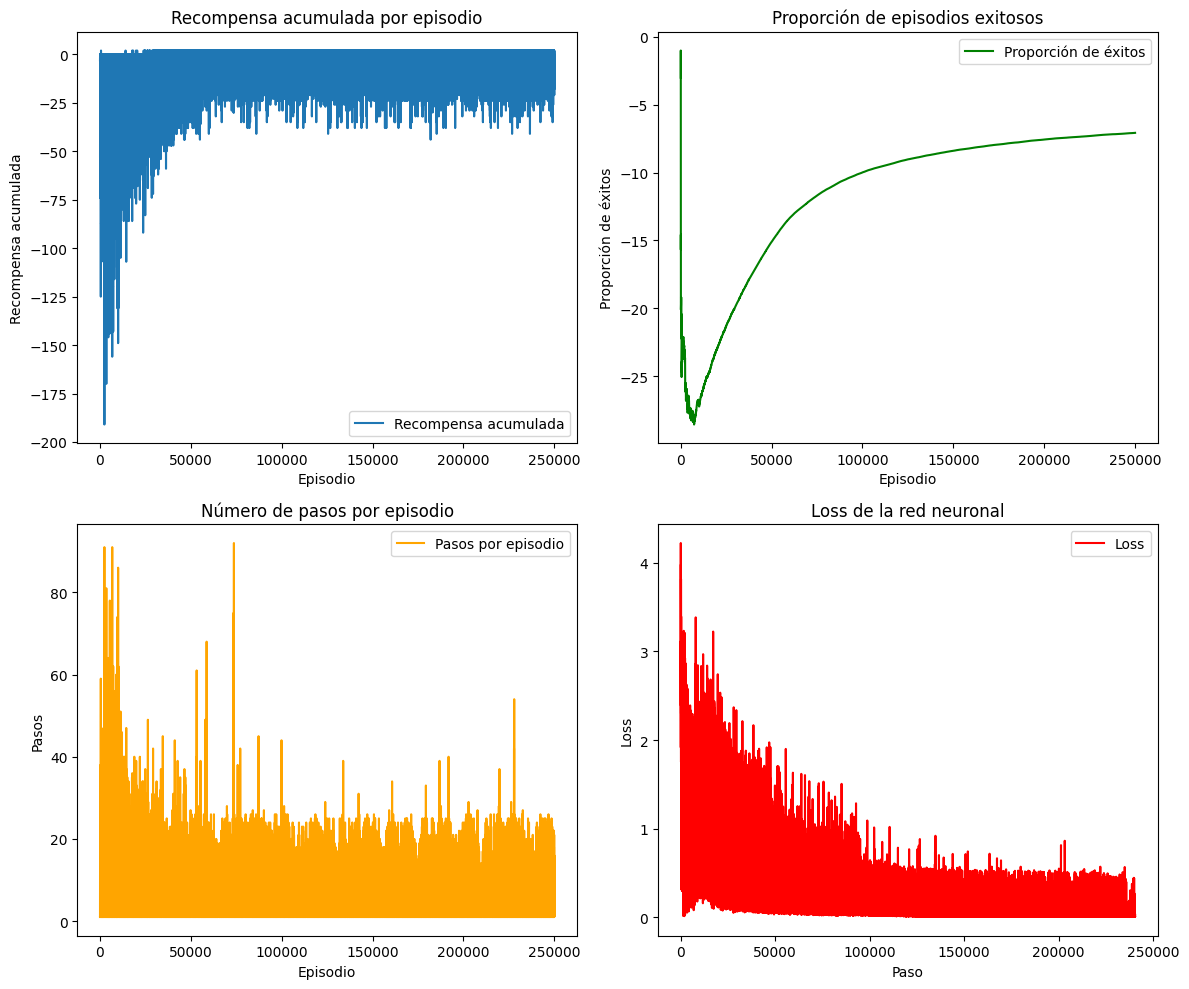

In [117]:
# Configuración del entorno y revisión
env2 = CrossStreetEnv2(num_lanes=6, street_length=20)
check_env(env2)

# Configuración de la red neuronal
policy_kwargs = dict(net_arch=[128, 128])
model2 = DQN(
    "MlpPolicy",
    env2,
    policy_kwargs=policy_kwargs,
    learning_rate=5e-4,
    buffer_size=100000,
    learning_starts=1000,
    batch_size=64,
    target_update_interval=1000,
    exploration_fraction=0.2,
    exploration_final_eps=0.05,
    verbose=0
)

# Entrenamiento del modelo con callback
loss_callback = LossLoggerCallback()
model2.learn(total_timesteps=250000, callback=loss_callback)

# Graficar métricas de entrenamiento
env2.plot_training_metrics(loss_callback.losses)

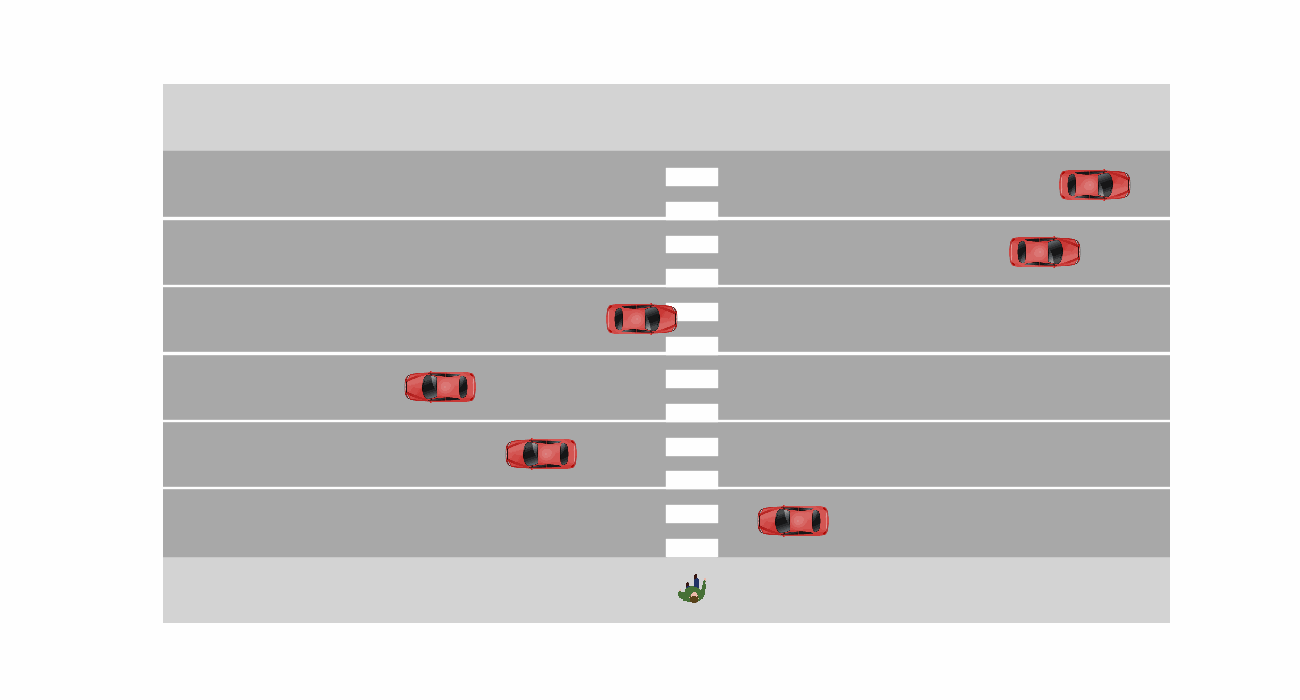

In [141]:
# Evaluación y visualización
obs, _ = env2.reset()
env2.render()

done = False
while not done:
    action, _ = model2.predict(obs, deterministic=True)
    obs, reward, done, _, _ = env2.step(action)
    env2.render()  # Visualización de cada paso para pruebas

# Crear animación con los frames guardados
frames = [Image.open(frame) for frame in env2.frames]
frames[0].save("cross_street_animation2.gif", save_all=True, append_images=frames[1:], loop=0, duration=300)

display(IPImage(filename="cross_street_animation2.gif"))

-----------

#### *Escenario 3*

En el tercer escenario, se presenta un entorno de simulación con un paso de cebra y vehículos que se mueven en ambas direcciones, pero ahora los carros tienen velocidades diferentes. El agente debe aprender a cruzar la calle de forma segura, evitando ser atropellado por los vehículos que se desplazan en ambas direcciones. El agente recibe una recompensa positiva al llegar al otro lado de la calle y una recompensa negativa si es atropellado.

In [124]:
class CrossStreetEnv3(gym.Env):
    def __init__(self, num_lanes=4, street_length=10):
        super(CrossStreetEnv3, self).__init__()

        num_lanes = int((num_lanes // 2) * 2)  # Asegurar que el número de carriles sea par
        street_length = max(10, street_length)

        # Definir dimensiones del entorno con aceras (arriba y abajo)
        self.num_lanes = num_lanes
        self.street_length = street_length
        self.observation_shape = (self.num_lanes + 2, self.street_length)  # +2 para las aceras
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=self.observation_shape, dtype=np.float32)
        self.action_space = gym.spaces.Discrete(3)

        # Variables para el registro de métricas
        self.total_rewards = []  # Recompensas acumuladas en cada episodio
        self.successful_episodes = 0  # Contador de episodios exitosos
        self.steps_per_episode = []  # Número de pasos por episodio
        self.rewards_history = []  # Histórico de recompensas acumuladas

        self.frames = []

        # Inicializar estado
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.np_random, _ = gym.utils.seeding.np_random(seed)

        # Limpiar y preparar directorio de frames
        for frame in os.listdir("./frames"):
            os.remove(f"./frames/{frame}")
        self.frames = []

        # Posición inicial del agente en la acera inferior
        self.agent_position = [self.num_lanes + 1, self.street_length // 2]
        self.vehicles = self._generate_vehicles()
        
        # Contador de pasos y recompensa acumulada
        self.current_steps = 0
        self.episode_reward = 0
        state = self._get_state().astype(np.float32)
        return state, {}

    def step(self, action):
        reward = -1  # Penalización por cada paso
        done = False

        # Mover al agente según la acción
        if action == 0:  # Retrocede
            self.agent_position[0] = max(0, self.agent_position[0] - 1)
            reward -= 2  # Penalización adicional por retroceder
        elif action == 1:  # Queda en su lugar
            reward -= 2
            if len(self.rewards_history) > 10 and all([r == -3 for r in self.rewards_history[-10:]]):
                done = True
                reward -= 10
        elif action == 2:  # Avanza
            self.agent_position[0] = min(self.num_lanes, self.agent_position[0] + 1)
            reward += 1  # Recompensa por avanzar en la dirección correcta

        # Actualizar posiciones de los vehículos con sus velocidades
        for i in range(self.num_lanes):
            if i < self.num_lanes // 2:  # Carriles que van de izquierda a derecha
                self.vehicles[i] = (self.vehicles[i] + self.vehicles_speeds[i]) % self.street_length
            else:  # Carriles que van de derecha a izquierda
                self.vehicles[i] = (self.vehicles[i] - self.vehicles_speeds[i]) % self.street_length

        # Verificar si el agente cruzó o tuvo una colisión
        if self.agent_position[0] == 0:  # Cruce exitoso
            reward += 20
            done = True
            self.successful_episodes += 1
        elif self._is_collision():  # Colisión
            reward -= 20
            done = True

        # Actualizar recompensa acumulada y conteo de pasos
        self.episode_reward += reward
        self.current_steps += 1

        self.record_episode_stats()

        state = self._get_state().astype(np.float32)
        return state, reward, done, False, {}

    def _generate_vehicles(self):
        # Genera posiciones iniciales en cada carril, asegurando una distancia segura entre vehículos
        self.vehicles = []
        self.vehicles_speeds = []

        for i in range(self.num_lanes):
            # Aseguramos una posición aleatoria inicial, separada de otros vehículos en el mismo carril
            if i < self.num_lanes // 2:  # Carriles de izquierda a derecha
                position = random.choice(range(0, self.street_length // 2))
            else:  # Carriles de derecha a izquierda
                position = random.choice(range(self.street_length // 2, self.street_length))

            # Asignar una velocidad para el vehículo
            if i > 0 and ((i < self.num_lanes // 2 and self.vehicles_speeds[i - 1] < 3) or (i >= self.num_lanes // 2 and self.vehicles_speeds[i - 1] > 1)):
                # Si hay un vehículo adelante en el mismo carril, dar una velocidad compatible
                speed = random.choice([v for v in range(1, 4) if v <= self.vehicles_speeds[i - 1]])
            else:
                # Velocidad aleatoria inicial
                speed = random.choice([1, 2, 3])

            self.vehicles.append(position)
            self.vehicles_speeds.append(speed)

        return self.vehicles

    def _is_collision(self):
        row, col = self.agent_position
        return 1 <= row <= self.num_lanes and col == self.vehicles[row - 1]

    def _get_state(self):
        state = np.zeros(self.observation_shape, dtype=np.float32)
        
        # Posición del agente
        state[self.agent_position[0], self.agent_position[1]] = 1
        
        # Colocar vehículos en los carriles
        for i, vehicle_pos in enumerate(self.vehicles):
            state[i + 1, vehicle_pos] = 0.5  # +1 para alinear con los carriles (excluyendo las aceras)

        return state

    def record_episode_stats(self):
        self.total_rewards.append(self.episode_reward)
        self.steps_per_episode.append(self.current_steps)
        self.rewards_history.append(self.episode_reward)

    def plot_training_metrics(self, loss):
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))

        # Gráfico 1: Recompensa acumulada por episodio
        axs[0][0].plot(self.total_rewards, label="Recompensa acumulada")
        axs[0][0].set_title("Recompensa acumulada por episodio")
        axs[0][0].set_xlabel("Episodio")
        axs[0][0].set_ylabel("Recompensa acumulada")
        axs[0][0].legend()

        # Gráfico 2: Cantidad de episodios exitosos
        successful_ratio = [sum(self.total_rewards[:i+1]) / (i+1) for i in range(len(self.total_rewards))]
        axs[0][1].plot(successful_ratio, label="Proporción de éxitos", color="green")
        axs[0][1].set_title("Proporción de episodios exitosos")
        axs[0][1].set_xlabel("Episodio")
        axs[0][1].set_ylabel("Proporción de éxitos")
        axs[0][1].legend()

        # Gráfico 3: Pasos por episodio
        axs[1][0].plot(self.steps_per_episode, label="Pasos por episodio", color="orange")
        axs[1][0].set_title("Número de pasos por episodio")
        axs[1][0].set_xlabel("Episodio")
        axs[1][0].set_ylabel("Pasos")
        axs[1][0].legend()

        # Gráfico 4: Loss de la red neuronal
        axs[1][1].plot(loss, label="Loss", color="red")
        axs[1][1].set_title("Loss de la red neuronal")
        axs[1][1].set_xlabel("Paso")
        axs[1][1].set_ylabel("Loss")
        axs[1][1].legend()

        plt.tight_layout()
        plt.show()

    def render(self):
        fig, ax = plt.subplots(figsize=(8+(self.street_length//4), 6+(self.num_lanes//4)))
        ax.set_xlim(-0.5, self.street_length - 0.5)
        ax.set_ylim(-0.5, self.num_lanes + 1.5)
        ax.set_xticks(range(self.street_length))
        ax.set_yticks(range(self.num_lanes + 2))
        ax.axis("off")

        # Load PNG images for agent and cars
        person_img = mpimg.imread("./imgs/personU.png")
        carL_img = mpimg.imread("./imgs/carL.png")
        carR_img = mpimg.imread("./imgs/carR.png")

        # Draw sidewalks (top and bottom)
        for x in range(self.street_length):
            ax.add_patch(patches.Rectangle((x - 0.5, -0.5), 1, 1, color="lightgray"))  # Bottom sidewalk
            ax.add_patch(patches.Rectangle((x - 0.5, self.num_lanes + 0.5), 1, 1, color="lightgray"))  # Top sidewalk

        # Draw street lanes and white lines between lanes
        skip = 0
        for lane in range(1, self.num_lanes + 1):
            for x in range(self.street_length):
                ax.add_patch(patches.Rectangle((x - 0.5, lane - 0.5), 1, 1, color="darkgray"))
            
            # Draw white lines between lanes
            if skip == 0:
                skip = 1
            else:
                if lane < self.num_lanes + 1:
                    for x in range(self.street_length):
                        ax.add_patch(patches.Rectangle((x - 0.5 , lane - 0.5), 1, 0.02, color="white"))

        # Draw a pedestrian crossing (zebra crossing) at x=0
        for lane in range(1, self.num_lanes+1):
            ax.add_patch(patches.Rectangle(((self.street_length // 2)-0.5, lane-0.5), 1, 0.25, color="white"))

            ax.add_patch(patches.Rectangle(((self.street_length // 2)-0.5, lane), 1, 0.25, color="white"))

        # Initialize agent and vehicle images as AnnotationBbox (to allow updating)
        agent_annot = AnnotationBbox(OffsetImage(person_img, zoom=0.01), 
                                    (self.agent_position[1], self.num_lanes + 1 - self.agent_position[0]), 
                                    frameon=False)
        ax.add_artist(agent_annot)
        
        vehicle_annots = []
        for lane in range(self.num_lanes):
            vehicle_pos = self.vehicles[lane]
            
            # Select the correct car image based on lane direction
            if lane < self.num_lanes // 2:
                car_img = carR_img  # Rightward-moving car
            else:
                car_img = carL_img  # Leftward-moving car

            # Add vehicle annotation
            vehicle_annot = AnnotationBbox(OffsetImage(car_img, zoom=0.2), 
                                        (vehicle_pos, self.num_lanes - lane), 
                                        frameon=False)
            vehicle_annots.append(vehicle_annot)
            ax.add_artist(vehicle_annot)

        # Update function for animation
        def update(frame):
            # Example agent movement
            self.agent_position[1] = (self.agent_position[1] + 1) % self.street_length
            agent_annot.xy = (self.agent_position[1], self.num_lanes + 1 - self.agent_position[0])
            
            # Example vehicle movement
            for lane in range(self.num_lanes):
                self.vehicles[lane] = (self.vehicles[lane] - 1) % self.street_length
                vehicle_annots[lane].xy = (self.vehicles[lane], self.num_lanes - lane)
            
            return [agent_annot] + vehicle_annots

        
        # Save the frame on ./frames folder as PNG
        self.frames.append(f"./frames/frame3_{len(self.frames)}.png")
        plt.savefig(self.frames[-1])
        plt.close(fig)

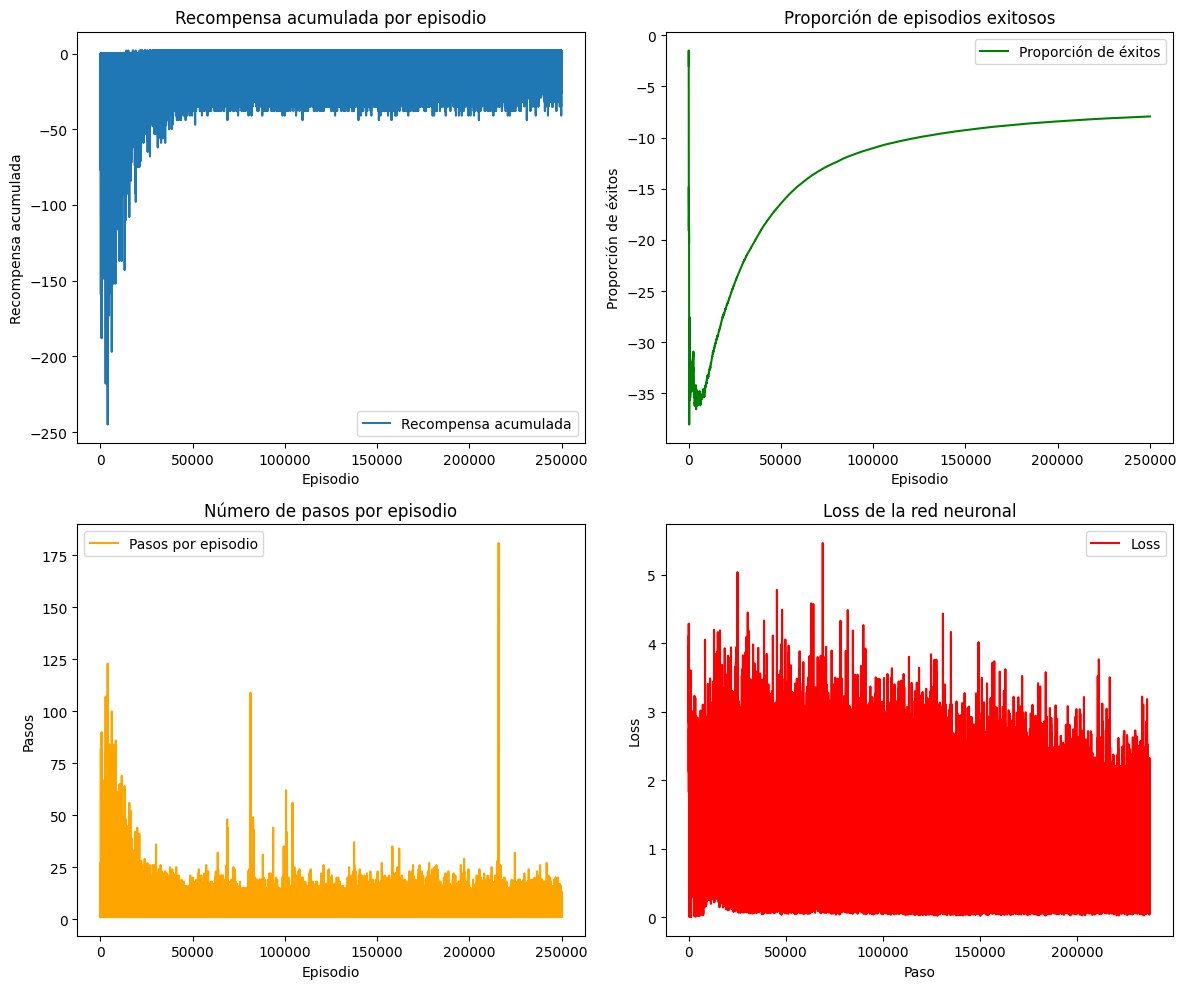

In [125]:
# Configuración y entrenamiento
env3 = CrossStreetEnv3(num_lanes=6, street_length=20)
check_env(env3)

policy_kwargs = dict(net_arch=[128, 128])
model3 = DQN(
    "MlpPolicy",
    env3,
    policy_kwargs=policy_kwargs,
    learning_rate=5e-4,
    buffer_size=100000,
    learning_starts=1000,
    batch_size=64,
    target_update_interval=1000,
    exploration_fraction=0.2,
    exploration_final_eps=0.05,
    verbose=0
)

loss_callback = LossLoggerCallback()
model3.learn(total_timesteps=250000, callback=loss_callback)
env3.plot_training_metrics(loss_callback.losses)

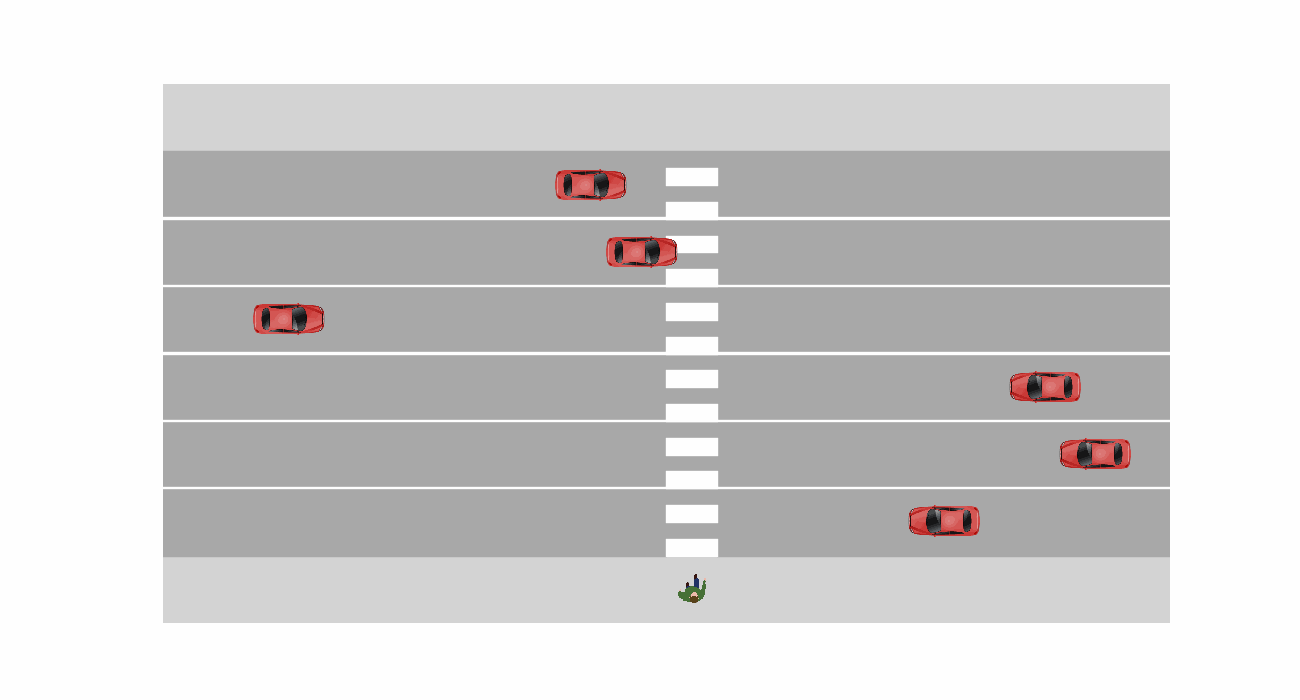

In [157]:
# Evaluación y visualización
obs, _ = env3.reset()
env3.render()

done = False
while not done:
    action, _ = model3.predict(obs, deterministic=True)
    obs, reward, done, _, _ = env3.step(action)
    env3.render()  # Visualización de cada paso para pruebas

# Crear animación con los frames guardados
frames = [Image.open(frame) for frame in env3.frames]
frames[0].save("cross_street_animation3.gif", save_all=True, append_images=frames[1:], loop=0, duration=300)

display(IPImage(filename="cross_street_animation3.gif"))


-----------

#### *Escenario 4*

En el cuarto escenario, se presenta un entorno de simulación con un paso de cebra y vehículos que se mueven en ambas direcciones, pero ahora los carros pueden cambiar de carril. El agente debe aprender a cruzar la calle de forma segura, evitando ser atropellado por los vehículos que se desplazan en ambas direcciones y cambian de carril. El agente recibe una recompensa positiva al llegar al otro lado de la calle y una recompensa negativa si es atropellado.

In [167]:
class CrossStreetEnv4(gym.Env):
    def __init__(self, num_lanes=4, street_length=10, cars_per_lane=1):
        super(CrossStreetEnv4, self).__init__()

        num_lanes = int((num_lanes//2)*2)            # Asegurar que el número de carriles sea par
        street_length = max(10, street_length)

        self.num_lanes = num_lanes
        self.street_length = street_length
        self.cars_per_lane = cars_per_lane
        self.observation_shape = (self.num_lanes + 2, self.street_length)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=self.observation_shape, dtype=np.float32)
        self.action_space = gym.spaces.Discrete(3)

        # Variables para el registro de métricas
        self.total_rewards = []
        self.successful_episodes = 0
        self.steps_per_episode = []
        self.rewards_history = []
        self.frames = []

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.np_random, _ = gym.utils.seeding.np_random(seed)

        # Limpiar y preparar directorio de frames
        for frame in os.listdir("./frames"): 
            os.remove(f"./frames/{frame}")
        self.frames = []
        
        self.agent_position = [self.num_lanes+1, self.street_length // 2]
        # Crear estructura 2D para vehículos: [carril][lista de posiciones de carros en ese carril]
        self.vehicles = self._generate_vehicles()
        
        self.current_steps = 0
        self.episode_reward = 0
        state = self._get_state().astype(np.float32)
        return state, {}

    def _generate_vehicles(self):
        # Crear una lista 2D donde cada carril tiene una lista de posiciones de vehículos
        vehicles = [[] for _ in range(self.num_lanes)]
        for lane in range(self.num_lanes):
            # Generar posiciones aleatorias para los vehículos en este carril
            num_cars = 1
            possible_positions = list(range(self.street_length))
            self.np_random.shuffle(possible_positions)
            vehicles[lane] = possible_positions[:num_cars]  # Tomar num_cars posiciones aleatorias
        return vehicles

    def step(self, action):
        reward = -1  # Penalización por cada paso
        done = False

        # Mover al agente según la acción
        if action == 0:  # Retrocede
            self.agent_position[0] = max(0, self.agent_position[0] - 1)
            reward -= 2  # Penalización adicional por retroceder
        elif action == 1:  # Queda en su lugar
            reward -= 2
            if len(self.rewards_history) > 10 and all([r == -3 for r in self.rewards_history[-10:]]):
                done = True
                reward -= 10
        elif action == 2:  # Avanza
            self.agent_position[0] = min(self.num_lanes, self.agent_position[0] + 1)
            reward += 1  # Recompensa por avanzar en la dirección correcta

        # Actualizar posiciones de los vehículos con sus velocidades
        self._move_vehicles()

        # Verificar si el agente cruzó o tuvo una colisión
        if self.agent_position[0] == 0:  # Cruce exitoso
            reward += 20
            done = True
            self.successful_episodes += 1
        elif self._is_collision():  # Colisión
            reward -= 20
            done = True

        # Actualizar recompensa acumulada y conteo de pasos
        self.episode_reward += reward
        self.current_steps += 1

        self.record_episode_stats()

        state = self._get_state().astype(np.float32)
        return state, reward, done, False, {}

    def _move_vehicles(self):

        new_vehicles = [[] for _ in range(self.num_lanes)]
        
        for lane in range(self.num_lanes):
            for car_pos in self.vehicles[lane]:
                # Decidir si el carro intenta cambiar de carril
                if self.np_random.random() < 0.1:  # 25% de probabilidad de cambio
                    possible_lanes = []
                    
                    # Verificar carriles adyacentes disponibles
                    if lane >= 0 and lane < self.num_lanes // 2:  # Carriles hacia la derecha
                        if lane == 0:
                            possible_lanes.append(lane+1)
                        elif lane == self.num_lanes // 2 - 1:
                            possible_lanes.append(lane-1)
                        else:
                            possible_lanes.extend([lane-1, lane+1])
                    else:  # Carriles hacia la izquierda
                        if lane == self.num_lanes // 2:
                            possible_lanes.append(lane+1)
                        elif lane == self.num_lanes - 1:
                            possible_lanes.append(lane-1)
                        else:
                            possible_lanes.extend([lane-1, lane+1])

                    if possible_lanes:
                        new_lane = self.np_random.choice(possible_lanes)

                        # Verificar si la nueva posición está libre
                        cars_in_lane = [pos for pos in self.vehicles[new_lane]]

                        if (car_pos not in cars_in_lane) and (car_pos+1 not in cars_in_lane) and (car_pos-1 not in cars_in_lane):
                            new_vehicles[new_lane].append(car_pos)
                        else:
                            new_vehicles[lane].append(car_pos)

                else:
                    new_vehicles[lane].append(car_pos)

        vehicles = [[] for _ in range(self.num_lanes)]        
        for lane in range(self.num_lanes):
            for car_pos in new_vehicles[lane]:
                new_pos = (car_pos + (1 if lane < self.num_lanes // 2 else -1)) % self.street_length
                vehicles[lane].append(new_pos)

        self.vehicles = vehicles

    def _is_collision(self):
        row, col = self.agent_position
        
        for lane in range(self.num_lanes):
            for vehicle_pos in self.vehicles[lane]:
                if row == lane + 1 and col == vehicle_pos:
                    return True
        return False

    def _get_state(self):
        state = np.zeros(self.observation_shape, dtype=np.float32)
        
        # Posición del agente
        state[self.agent_position[0], self.agent_position[1]] = 1
        
        # Colocar vehículos en los carriles
        for lane in range(self.num_lanes):
            for vehicle_pos in self.vehicles[lane]:
                state[lane + 1, vehicle_pos] = 0.5

        return state

    def record_episode_stats(self):
        self.total_rewards.append(self.episode_reward)
        self.steps_per_episode.append(self.current_steps)
        self.rewards_history.append(self.episode_reward)

    def plot_training_metrics(self, loss):
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))

        # Gráfico 1: Recompensa acumulada por episodio
        axs[0][0].plot(self.total_rewards, label="Recompensa acumulada")
        axs[0][0].set_title("Recompensa acumulada por episodio")
        axs[0][0].set_xlabel("Episodio")
        axs[0][0].set_ylabel("Recompensa acumulada")
        axs[0][0].legend()

        # Gráfico 2: Cantidad de episodios exitosos
        successful_ratio = [sum(self.total_rewards[:i+1]) / (i+1) for i in range(len(self.total_rewards))]
        axs[0][1].plot(successful_ratio, label="Proporción de éxitos", color="green")
        axs[0][1].set_title("Proporción de episodios exitosos")
        axs[0][1].set_xlabel("Episodio")
        axs[0][1].set_ylabel("Proporción de éxitos")
        axs[0][1].legend()

        # Gráfico 3: Pasos por episodio
        axs[1][0].plot(self.steps_per_episode, label="Pasos por episodio", color="orange")
        axs[1][0].set_title("Número de pasos por episodio")
        axs[1][0].set_xlabel("Episodio")
        axs[1][0].set_ylabel("Pasos")
        axs[1][0].legend()

        # Gráfico 4: Loss de la red neuronal
        axs[1][1].plot(loss, label="Loss", color="red")
        axs[1][1].set_title("Loss de la red neuronal")
        axs[1][1].set_xlabel("Paso")
        axs[1][1].set_ylabel("Loss")
        axs[1][1].legend()

        plt.tight_layout()
        plt.show()

    def render(self):
        fig, ax = plt.subplots(figsize=(8+(self.street_length//4), 6+(self.num_lanes//4)))
        ax.set_xlim(-0.5, self.street_length - 0.5)
        ax.set_ylim(-0.5, self.num_lanes + 1.5)
        ax.set_xticks(range(self.street_length))
        ax.set_yticks(range(self.num_lanes + 2))
        ax.axis("off")

        # Load PNG images
        person_img = mpimg.imread("./imgs/personU.png")
        carL_img = mpimg.imread("./imgs/carL.png")
        carR_img = mpimg.imread("./imgs/carR.png")

        # Draw sidewalks
        for x in range(self.street_length):
            ax.add_patch(patches.Rectangle((x - 0.5, -0.5), 1, 1, color="lightgray"))
            ax.add_patch(patches.Rectangle((x - 0.5, self.num_lanes + 0.5), 1, 1, color="lightgray"))

        # Draw street lanes and white lines
        skip = 0
        for lane in range(1, self.num_lanes + 1):
            for x in range(self.street_length):
                ax.add_patch(patches.Rectangle((x - 0.5, lane - 0.5), 1, 1, color="darkgray"))
            
            if skip == 0:
                skip = 1
            else:
                if lane < self.num_lanes + 1:
                    for x in range(self.street_length):
                        ax.add_patch(patches.Rectangle((x - 0.5, lane - 0.5), 1, 0.02, color="white"))

        # Draw pedestrian crossing
        for lane in range(1, self.num_lanes+1):
            ax.add_patch(patches.Rectangle(((self.street_length // 2)-0.5, lane-0.5), 1, 0.25, color="white"))
            ax.add_patch(patches.Rectangle(((self.street_length // 2)-0.5, lane), 1, 0.25, color="white"))

        # Draw agent
        agent_annot = AnnotationBbox(OffsetImage(person_img, zoom=0.01), 
                                   (self.agent_position[1], self.num_lanes + 1 - self.agent_position[0]), 
                                   frameon=False)
        ax.add_artist(agent_annot)
        
        # Draw vehicles
        vehicle_annots = []
        for lane in range(self.num_lanes):
            for vehicle_pos in self.vehicles[lane]:
                car_img = carR_img if lane < self.num_lanes // 2 else carL_img
                vehicle_annot = AnnotationBbox(OffsetImage(car_img, zoom=0.2), 
                                             (vehicle_pos, self.num_lanes - lane), 
                                             frameon=False)
                vehicle_annots.append(vehicle_annot)
                ax.add_artist(vehicle_annot)

        self.frames.append(f"./frames/frame4_{len(self.frames)}.png")
        plt.savefig(self.frames[-1])
        plt.close(fig)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:263: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


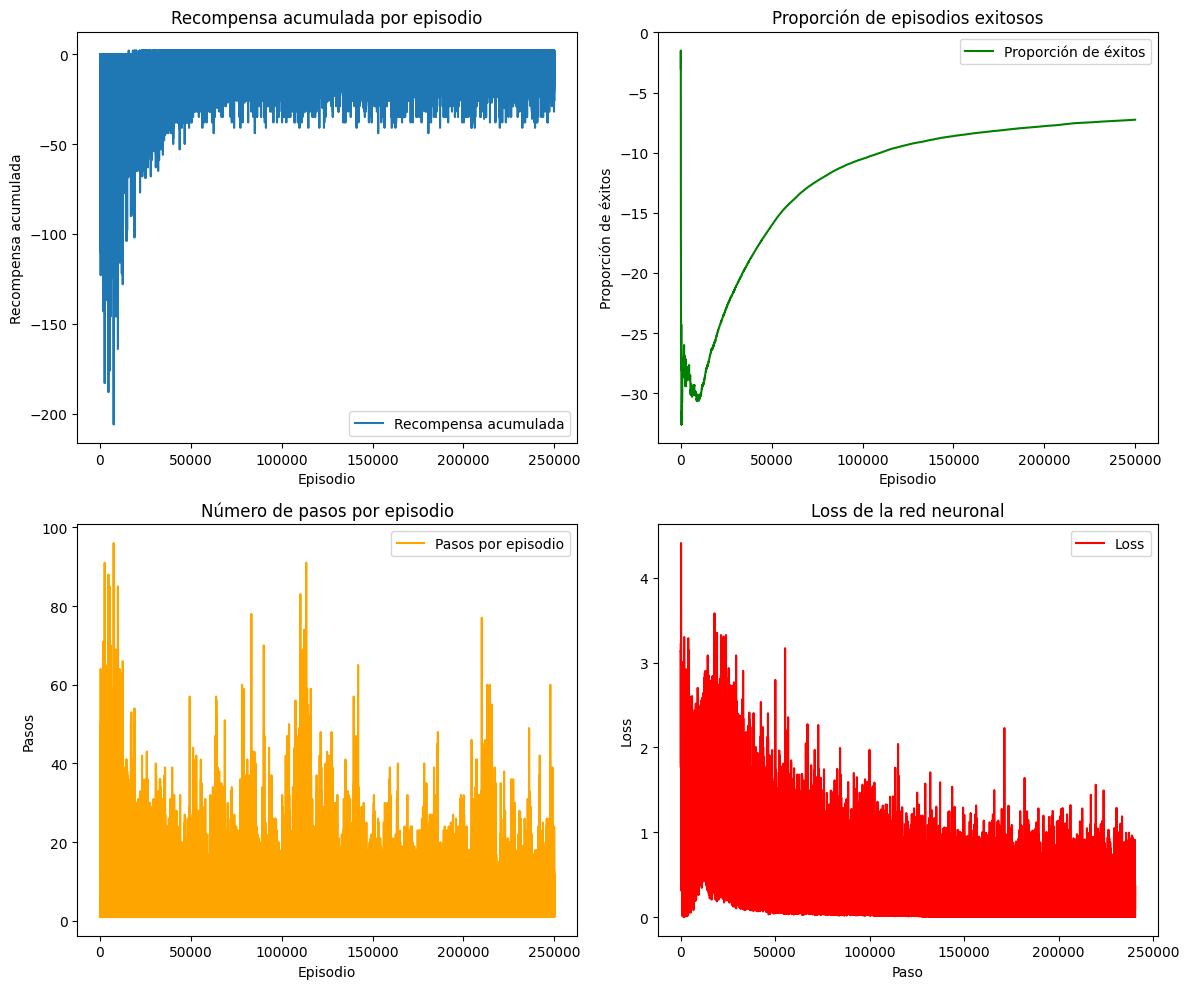

In [168]:
# Configuración del entorno y revisión
env4 = CrossStreetEnv4(num_lanes=6, street_length=20)
check_env(env4)

# Configuración del modelo DQN
policy_kwargs = dict(net_arch=[128, 128])
model4 = DQN(
    "MlpPolicy",
    env4,
    policy_kwargs=policy_kwargs,
    learning_rate=5e-4,
    buffer_size=100000,
    learning_starts=1000,
    batch_size=64,
    target_update_interval=1000,
    exploration_fraction=0.2,
    exploration_final_eps=0.05,
    verbose=0
)

# Entrenar modelo y visualizar
loss_callback = LossLoggerCallback()
model4.learn(total_timesteps=250000, callback=loss_callback)
env4.plot_training_metrics(loss_callback.losses)

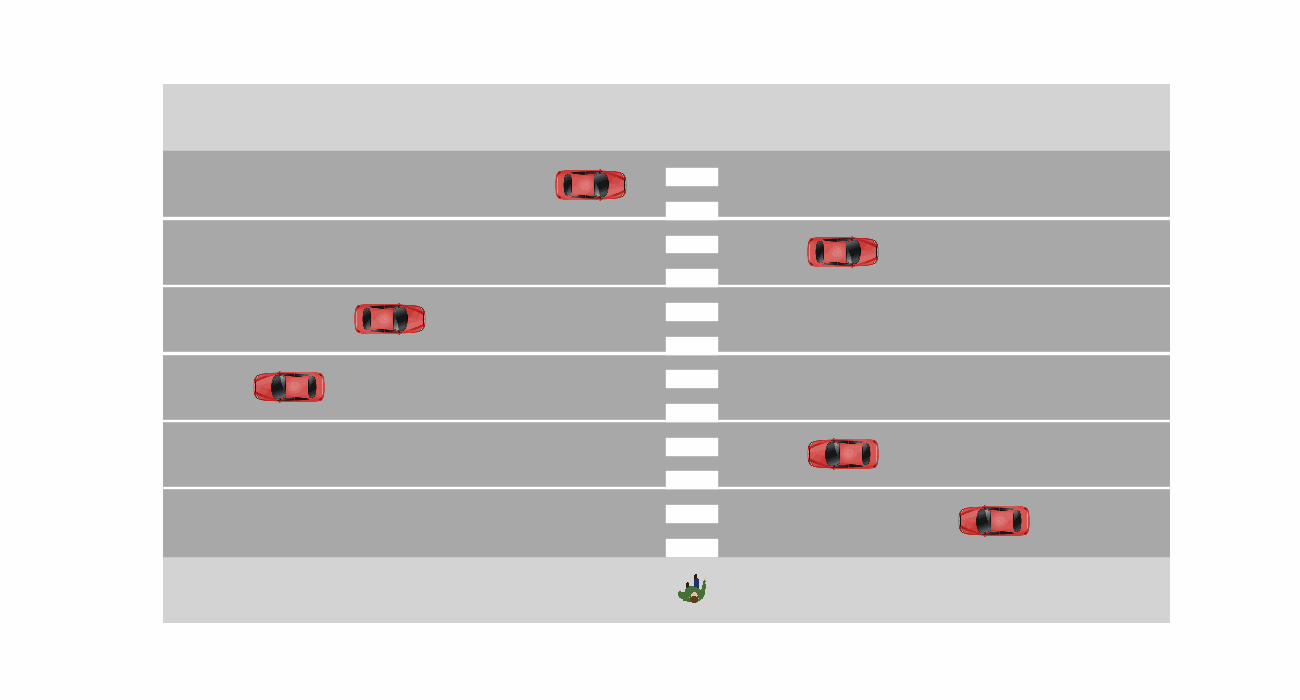

In [169]:
obs, _ = env4.reset()
env4.render()

done = False
while not done:
    action, _ = model4.predict(obs, deterministic=True)
    obs, reward, done, _, _ = env4.step(action)
    env4.render()

# Crear animación con frames
frames = [Image.open(frame) for frame in env4.frames]
frames[0].save("cross_street_animation4.gif", save_all=True, append_images=frames[1:], loop=0, duration=300)

display(IPImage(filename="cross_street_animation4.gif"))